In [2]:
from util_plot import AbundPlot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import socket
from solar_rs import element2z_dict, z2element_dict, \
    logeps_sols, logeps_solr, logeps_sols_dict, logeps_solr_dict

from starfit import Single
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import seaborn as sns

exp10 = lambda x: np.power(10, x)
log10 = np.log10

In [9]:
aplt = AbundPlot(datafile='logeps.csv')
star_name = 'J0804+5740'
aplt.load_star(star_name)
logeps_star_heavy = np.array(aplt.star_logeps_heavy, float)
elogeps_star_heavy = np.array(aplt.star_elogeps_heavy, float)
fig = aplt.plot()
fig.savefig(fname='%s_solar.png'%star_name)

In [10]:
ks, dks = aplt.ks, aplt.dks
kr, dkr = aplt.kr, aplt.dkr
plot_Z = aplt.plot_Z
Z_star_detect = aplt.star_Z_heavy
logeps_sols_detect = logeps_sols[np.in1d(plot_Z, Z_star_detect)]

exp10_nons = exp10(logeps_star_heavy) - ks*exp10(logeps_sols_detect)
flag_abv0 = exp10_nons > 0
exp10_nons[~flag_abv0] = exp10(logeps_star_heavy[~flag_abv0])
logeps_nons = log10(exp10_nons)
eexp10_nons = exp10(logeps_star_heavy+elogeps_star_heavy) - (ks+dks)*exp10(logeps_sols_detect)
# define the invalid data to uppper limit
eexp10_nons[~flag_abv0] = exp10(logeps_nons[~flag_abv0] - 1)
elogeps_nons = np.log10(eexp10_nons) - logeps_nons
elogeps_nons[~flag_abv0] = -1
element_nons = np.array([z2element_dict[_] for _ in Z_star_detect])

datpath = '%s.dat'%star_name
with open(datpath, 'w') as file:
    file.write('10002\n')
    file.write('%s\n'%(star_name))
    file.write('%s\n'%(''))
    file.write('%s\n'%(''))
    file.write('1\n')
    file.write('\n')
    file.write('%s\n'%(len(logeps_nons)))
    for _el, _logeps, _elogeps in zip(element_nons, logeps_star_heavy, elogeps_nons):
        el_line = '%-3s  %5.2f  %5.2f'%(_el, _logeps, _elogeps)
        file.write('%s\n'%(el_line))
    file.write('-')

In [17]:
database = [
    'rproc.wu.star.el.y.stardb.xz', 
    'rproc.just15.star.el.y.stardb.xz', 
    'nuc.lc18.star.el.y.stardb.xz', 
    'znuc2012.S4.star.el.y.stardb.gz', 
]

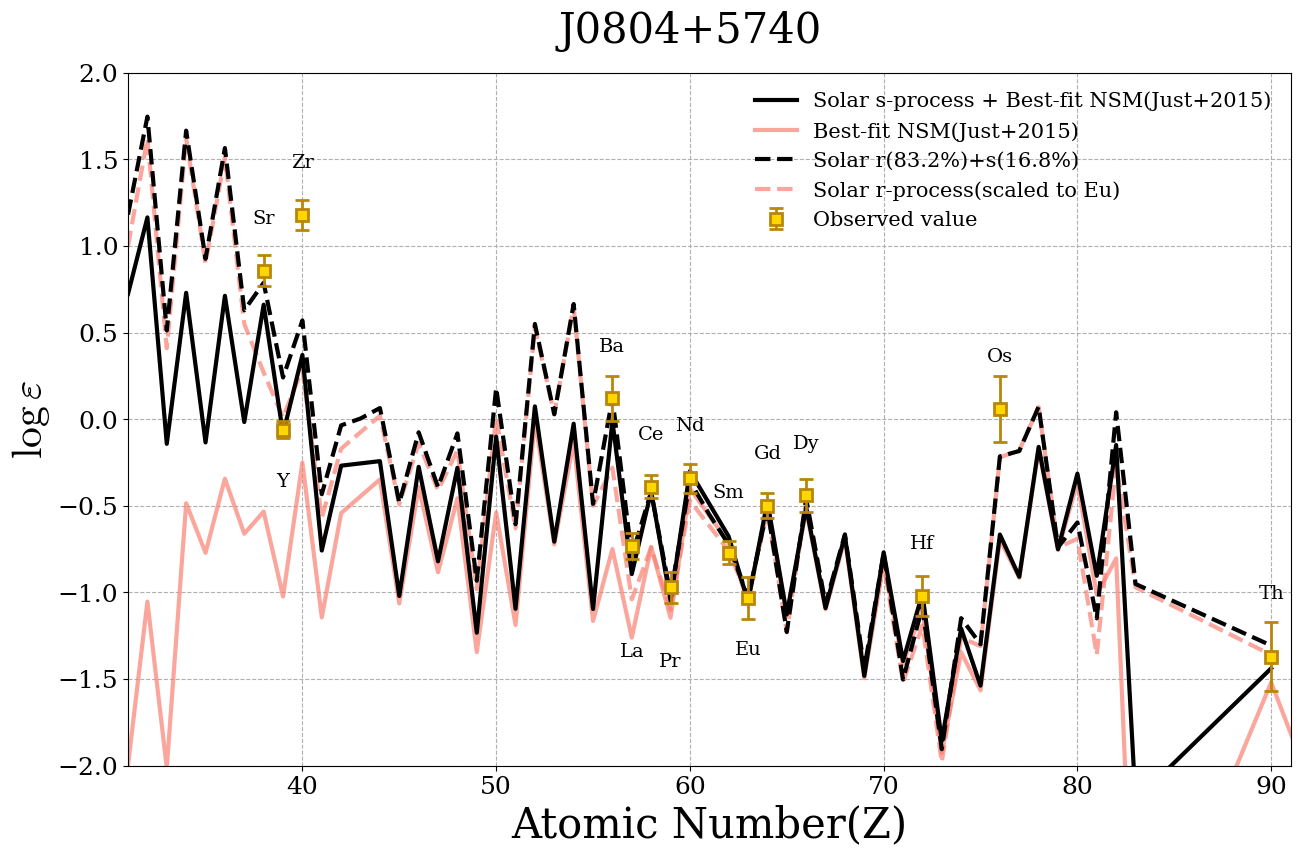

In [5]:
sing = Single(
    datpath, db=database[1],
    z_min=31, z_max=90, 
    z_lolim=[38, 39, 40], 
    upper_lim=True, 
    silent=True
)
bfmod_index = sing.sorted_stars[0]['index'][0]
bfmod_offset = sing.sorted_stars[0]['offset'][0]
bfmod_logeps = log10(sing.db[0].data[bfmod_index]) + log10(bfmod_offset) + 12# - log10(sing.db[0].data[bfmod_index, :].sum())
bfmod_param = sing.db[0].fielddata[bfmod_index]
bfmod_paramname = sing.db[0].fieldnames
bfmod_Z = np.array([_.Z for _ in sing.db[0].ions])
fig, ax = plt.subplots(
    1, 1, figsize=(15, 9), 
    dpi=100, sharex=True)
fig.subplots_adjust(hspace=.1)
logeps_solr_scaled = aplt.logeps_solr_scaled
logeps_sols_scaled = aplt.logeps_sols_scaled
logeps_solrs_scaled = aplt.logeps_solrs_scaled
intersect_Z = np.intersect1d(bfmod_Z, plot_Z)
bfmod_rs = log10(exp10(bfmod_logeps[np.in1d(bfmod_Z, intersect_Z)])\
    + exp10(logeps_sols[np.in1d(plot_Z, intersect_Z)])*ks)
ax.plot(
    intersect_Z, bfmod_rs, 
    linewidth=3, c='k', 
    label="Solar s-process + Best-fit NSM(Just+2015)", 
    zorder=5)
ax.plot(
    bfmod_Z, bfmod_logeps, 
    linewidth=3, c='salmon', alpha=.7, 
    label="Best-fit NSM(Just+2015)", 
    zorder=2)
scaled_kr = 100*kr/(kr+ks)
scaled_ks = 100*ks/(kr+ks)
ax.plot(plot_Z, logeps_solrs_scaled, 
    linewidth=3, c='k', linestyle='--',
    label="Solar r(%.1f%%)+s(%.1f%%)"%(scaled_kr, scaled_ks), 
    zorder=5)
ax.plot(
    plot_Z, logeps_solr_scaled, 
    linewidth=3, c='salmon', alpha=.7, linestyle='--',
    label="Solar r-process(scaled to Eu)", 
    zorder=2)
ec = 'darkgoldenrod'
ew = 2
ax.errorbar(
    Z_star_detect, logeps_star_heavy, yerr=elogeps_star_heavy,
    ecolor=ec, elinewidth=ew, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=8, mfc='gold', mec=ec, mew=ew,
    label='Observed value', 
    alpha=1, zorder=7)
for _idx, _x in enumerate(Z_star_detect):
    dist = .3
    _t = z2element_dict[_x]
    idx_x = np.argmin(np.abs(plot_Z - _x))
    _y = logeps_solrs_scaled[idx_x]
    sign_pos = +1
    if (idx_x != 0) and (idx_x != len(plot_Z)-1):
        if (logeps_solrs_scaled[idx_x-1] > _y) and (logeps_solrs_scaled[idx_x+1] > _y):
            sign_pos = -1
    if sign_pos < 0:
        _y = np.min([
            logeps_star_heavy[_idx], 
            logeps_solr_scaled[idx_x], 
            _y])
    else:
        _y = np.max([
            logeps_star_heavy[_idx], 
            logeps_solr_scaled[idx_x], 
            _y])
    _y += (sign_pos * dist)
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
ax.grid(True, linestyle='--', alpha=1, zorder=1)
ax.set_ylim(-2, 2)
ax.set_xlim(31, 91)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Atomic Number(Z)", size=30)
ax.set_ylabel(r'$\log\varepsilon$', size=30)
fig.suptitle(star_name, y=.95, size=30)

ax.legend(loc='best', fontsize=15, frameon=False)
fig.savefig('%s_just2015.pdf'%star_name)

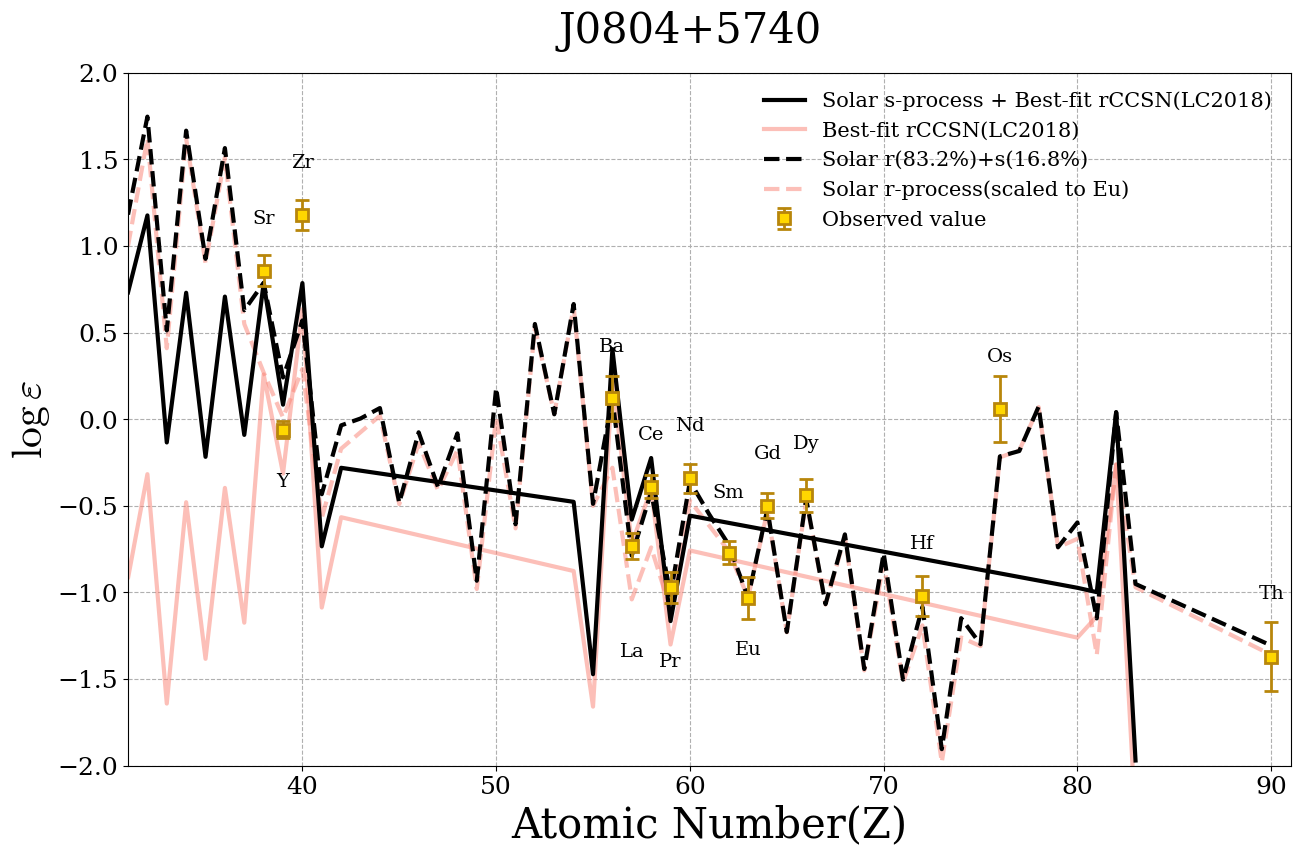

In [118]:
sing = Single(
    datpath, db=database[2],
    z_min=3, z_max=60, 
    upper_lim=True, 
    silent=True
)
bfmod_index = sing.sorted_stars[0]['index'][0]
bfmod_offset = sing.sorted_stars[0]['offset'][0]
bfmod_logeps = log10(sing.db[0].data[bfmod_index]) + log10(bfmod_offset) + 12# - log10(sing.db[0].data[bfmod_index, :].sum())
bfmod_param = sing.db[0].fielddata[bfmod_index]
bfmod_paramname = sing.db[0].fieldnames
bfmod_Z = np.array([_.Z for _ in sing.db[0].ions])
fig, ax = plt.subplots(
    1, 1, figsize=(15, 9), 
    dpi=100, sharex=True)
fig.subplots_adjust(hspace=.1)
logeps_solr_scaled = aplt.logeps_solr_scaled
logeps_sols_scaled = aplt.logeps_sols_scaled
logeps_solrs_scaled = aplt.logeps_solrs_scaled
intersect_Z = np.intersect1d(bfmod_Z, plot_Z)
bfmod_rs = log10(exp10(bfmod_logeps[np.in1d(bfmod_Z, intersect_Z)])\
    + exp10(logeps_sols[np.in1d(plot_Z, intersect_Z)])*ks)
ax.plot(
    intersect_Z, bfmod_rs, 
    linewidth=3, c='k', 
    label="Solar s-process + Best-fit rCCSN(LC2018)", 
    zorder=5)
ax.plot(
    bfmod_Z, bfmod_logeps, 
    linewidth=3, c='salmon', alpha=.7, 
    label="Best-fit rCCSN(LC2018)", 
    zorder=2)
scaled_kr = 100*kr/(kr+ks)
scaled_ks = 100*ks/(kr+ks)
ax.plot(plot_Z, logeps_solrs_scaled, 
    linewidth=3, c='k', linestyle='--',
    label="Solar r(%.1f%%)+s(%.1f%%)"%(scaled_kr, scaled_ks), 
    zorder=5)
ax.plot(
    plot_Z, logeps_solr_scaled, 
    linewidth=3, c='salmon', alpha=.7, linestyle='--',
    label="Solar r-process(scaled to Eu)", 
    zorder=2)
ec = 'darkgoldenrod'
ew = 2
ax.errorbar(
    Z_star_detect, logeps_star_heavy, yerr=elogeps_star_heavy,
    ecolor=ec, elinewidth=ew, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=8, mfc='gold', mec=ec, mew=ew,
    label='Observed value', 
    alpha=1, zorder=7)
for _idx, _x in enumerate(Z_star_detect):
    dist = .3
    _t = z2element_dict[_x]
    idx_x = np.argmin(np.abs(plot_Z - _x))
    _y = logeps_solrs_scaled[idx_x]
    sign_pos = +1
    if (idx_x != 0) and (idx_x != len(plot_Z)-1):
        if (logeps_solrs_scaled[idx_x-1] > _y) and (logeps_solrs_scaled[idx_x+1] > _y):
            sign_pos = -1
    if sign_pos < 0:
        _y = np.min([
            logeps_star_heavy[_idx], 
            logeps_solr_scaled[idx_x], 
            _y])
    else:
        _y = np.max([
            logeps_star_heavy[_idx], 
            logeps_solr_scaled[idx_x], 
            _y])
    _y += (sign_pos * dist)
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
ax.grid(True, linestyle='--', alpha=1, zorder=1)
ax.set_ylim(-2, 2)
ax.set_xlim(31, 91)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Atomic Number(Z)", size=30)
ax.set_ylabel(r'$\log\varepsilon$', size=30)
fig.suptitle(star_name, y=.95, size=30)

ax.legend(loc='best', fontsize=15, frameon=False)
fig.savefig('%s_lc2018.pdf'%star_name)


In [119]:
from starfit.autils.abusets import SolAbu
sun = SolAbu('solas09.dat', silent=True)

Text(0.5, 0.95, 'J0804+5740')

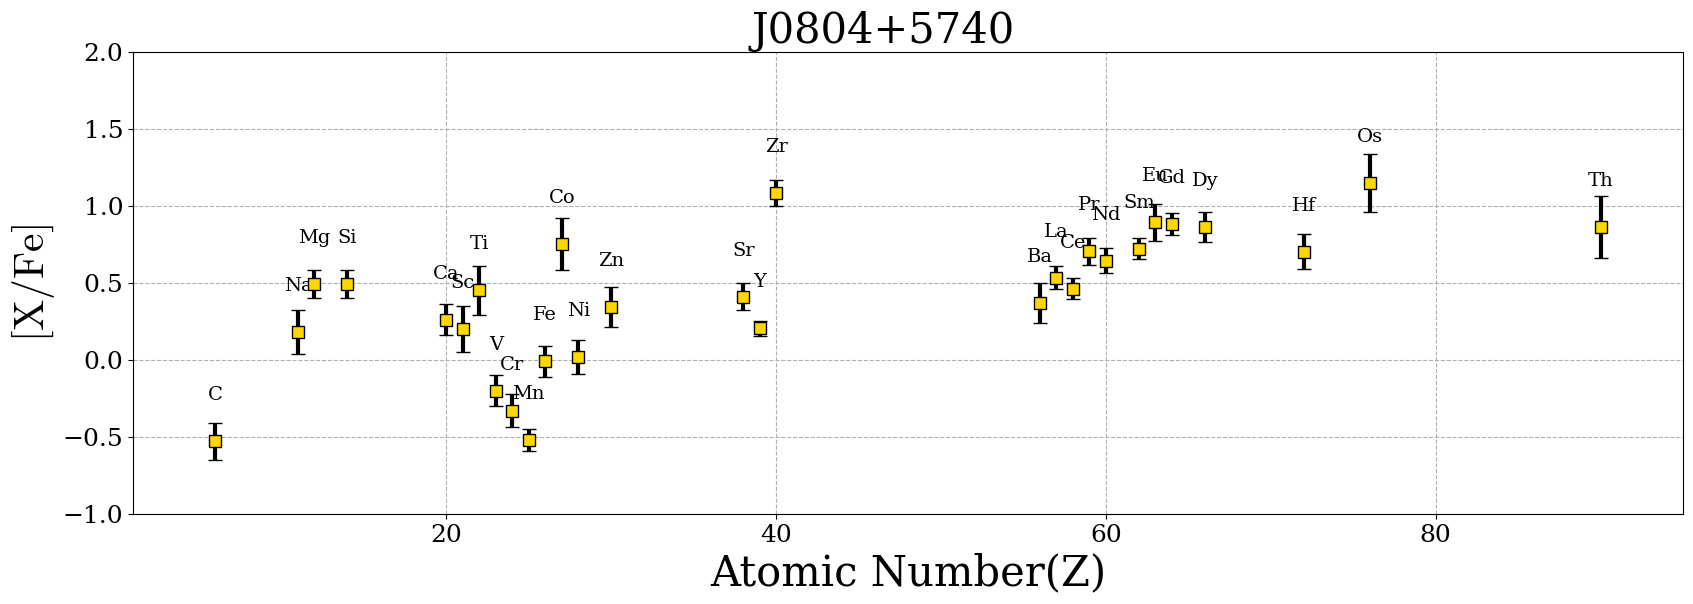

In [120]:
logeps_star = np.array(list(aplt.star_logeps_dict.values()))
elogeps_star = np.array(list(aplt.star_elogeps_dict.values()))
element_star = np.array(list(aplt.star_logeps_dict.keys()))
FeH = -2.47
XH_star = logeps_star-sun.log_eps(element_star)
XFe_star = logeps_star-sun.log_eps(element_star) - FeH
Z_star = np.array([element2z_dict[el] for el in element_star])
fig, ax = plt.subplots(
    1, 1, figsize=(20, 6), 
    dpi=100, sharex=True)
fig.subplots_adjust(hspace=.1)
ax.errorbar(
    Z_star, XFe_star, yerr=elogeps_star,
    ecolor='k', elinewidth=3, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=8, mfc='gold', mec='k', mew=1,
    label='Observed value', 
    alpha=1, zorder=7
)
for _idx, _x in enumerate(Z_star):
    dist = .3
    _t = z2element_dict[_x]
    _y = XFe_star[_idx]
    sign_pos = +1
    _y += (sign_pos * dist)
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=5)
ax.grid(True, linestyle='--', alpha=1, zorder=1)
ax.set_ylim(-1, 2)
ax.set_xlim(1, 95)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Atomic Number(Z)", size=30)
ax.set_ylabel(r'$\mathrm{[X/Fe]}$', size=30)
fig.suptitle(star_name, y=.95, size=30)

# ax.legend(loc='best', fontsize=15, frameon=False)
# fig.savefig('%s_wu2016.pdf'%star_name)

## Load NST2017 Yields

In [11]:
from util_plot import hostdir
aplt = AbundPlot(datafile='logeps.csv')
star_name = 'J0804+5740'
aplt.load_star(star_name)
ks, dks = aplt.ks, aplt.dks
kr, dkr = aplt.kr, aplt.dkr
logeps_star = np.array(list(aplt.star_logeps_dict.values()))
elogeps_star = np.array(list(aplt.star_elogeps_dict.values()))
element_star = np.array(list(aplt.star_logeps_dict.keys()))
plot_Z = aplt.plot_Z
Z_star = np.array([element2z_dict[el] for el in element_star])

In [12]:
yield_dir = hostdir.parent/'ssd/GitHub/EMPs_IMF/rproc/mrsn-gh-pages/nst2017/yields'

NST_Z = np.arange(1, 93, 1)
# NST_Lnu = []
NST_yield = []
for yield_path in yield_dir.iterdir():
    if not yield_path.suffix == '.dat':
        continue
    # Lnu = float(yield_path.stem[1:])
    # NST_Lnu.append(Lnu)
    yield_arr = np.zeros(len(NST_Z))
    with open(yield_path) as rfile:
        rlines = rfile.read().splitlines()
    for _line in rlines[7:]:
        line_split = _line.split()
        _Z = int(line_split[1])
        _Y = float(line_split[-1])
        yield_arr[_Z-1] += _Y
    NST_yield.append(yield_arr)
# NST_Lnu = np.array(NST_Lnu)
NST_yield = np.concatenate([NST_yield])

flag = np.unique(np.where(NST_Z>=6)[0])
NST_Z = NST_Z[flag]
NST_yield = NST_yield[:, flag]
NST_logpes = np.log10(NST_yield) - np.log10(NST_yield[:, [0]]) + 12

O_vec = np.full(len(NST_Z), np.nan)
eO_vec = np.full(len(NST_Z), np.nan)
O_vec[np.in1d(NST_Z, Z_star)] = logeps_star
eO_vec[np.in1d(NST_Z, Z_star)] = elogeps_star
Z_star_detect = NST_Z[~ np.isnan(O_vec)]

In [13]:
eM_vec = np.zeros(len(NST_Z))
flag_adopt = (NST_Z > 40)
def func_A(M_vec, O_vec, eO_vec):
    flag_detect = ~ np.isnan(O_vec)
    inv_err2 = 1/(np.square(eO_vec) + np.square(eM_vec))
    sum_inv_err2 = np.sum(inv_err2[flag_adopt & flag_detect])
    relative_res = (M_vec - O_vec) * inv_err2
    sum_relres = np.sum(relative_res[flag_adopt & flag_detect])
    A = - sum_relres / sum_inv_err2
    return A # - 0.15039942
def func_chisqr(M_vec, O_vec, eO_vec):
    flag_detect = ~ np.isnan(O_vec)
    A = func_A(M_vec, O_vec, eO_vec)
    AmM2_vec = np.power(A + M_vec - O_vec, 2)
    eAmM2_vec = np.power(eM_vec, 2) + np.power(eO_vec, 2)
    loglike_vec = AmM2_vec/eAmM2_vec
    chisqr = np.sum(loglike_vec[flag_adopt & flag_detect])
    return chisqr

In [14]:
chisqr_arr = []
for i in range(NST_logpes.shape[0]):
    chisqr = func_chisqr(NST_logpes[i, :], O_vec, eO_vec)
    chisqr_arr.append(chisqr)
chisqr_arr = np.array(chisqr_arr)

In [15]:
bf_idx = chisqr_arr.argsort()[0]
M_vec = NST_logpes[bf_idx, :]
A = func_A(M_vec, O_vec, eO_vec)
print(bf_idx, A, chisqr_arr[bf_idx])

6 -14.983085525061774 138.05487114946408


In [18]:
sing = Single(
    datpath, db=database[1],
    z_min=31, z_max=90, 
    z_lolim=[38, 39, 40], 
    upper_lim=True, 
    silent=True
)
bfmod_index = sing.sorted_stars[0]['index'][0]
bfmod_offset = sing.sorted_stars[0]['offset'][0]
bfmod_logeps = log10(sing.db[0].data[bfmod_index]) + log10(bfmod_offset) + 12# - log10(sing.db[0].data[bfmod_index, :].sum())
bfmod_Z = np.array([_.Z for _ in sing.db[0].ions])

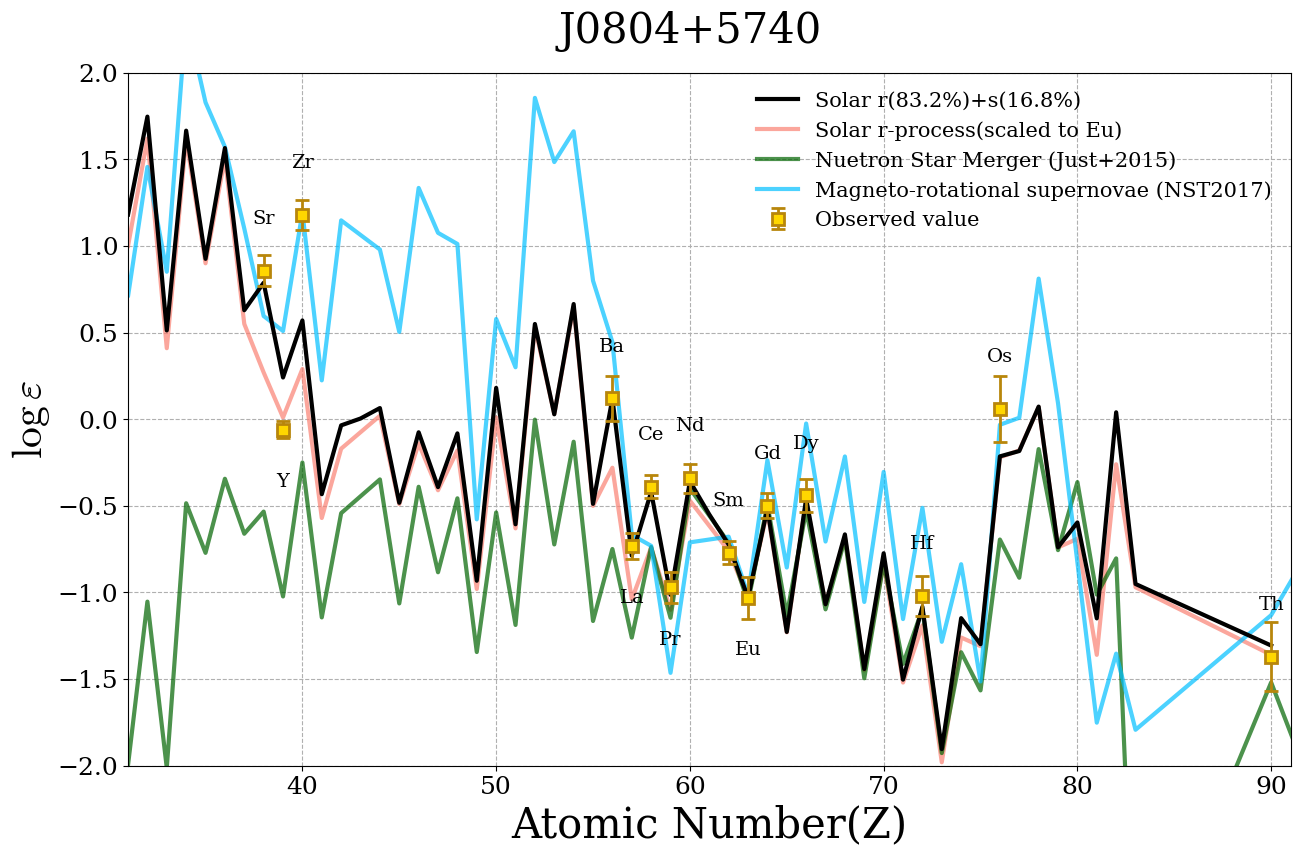

In [20]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 9), 
    dpi=100, sharex=True)
fig.subplots_adjust(hspace=.1)
logeps_solr_scaled = aplt.logeps_solr_scaled
logeps_sols_scaled = aplt.logeps_sols_scaled
logeps_solrs_scaled = aplt.logeps_solrs_scaled
scaled_kr = 100*kr/(kr+ks)
scaled_ks = 100*ks/(kr+ks)
flag_finite = np.isfinite(M_vec+A)
flag_plot = NST_Z > 30
flag_detect = ~ np.isnan(O_vec)
flag_star = flag_plot & flag_detect
ax.errorbar(
    NST_Z[flag_star], O_vec[flag_star], yerr=eO_vec[flag_star],
    ecolor='darkgoldenrod', elinewidth=2, linestyle='', capsize=5, capthick=3,
    marker='s', markersize=8, mfc='gold', mec='darkgoldenrod', mew=2,
    label='Observed value', 
    alpha=1, zorder=7)
ax.plot(plot_Z, logeps_solrs_scaled, 
    linewidth=3, c='k', linestyle='solid',
    label="Solar r(%.1f%%)+s(%.1f%%)"%(scaled_kr, scaled_ks), 
    zorder=5)
ax.plot(
    plot_Z, logeps_solr_scaled, 
    linewidth=3, c='salmon', alpha=.7, linestyle='solid',
    label="Solar r-process(scaled to Eu)", 
    zorder=2)
ax.plot(
    bfmod_Z, bfmod_logeps, 
    linewidth=3, c='darkgreen', alpha=.7, 
    label="Nuetron Star Merger (Just+2015)", 
    zorder=2)
ax.plot(
    NST_Z[flag_finite], (M_vec+A)[flag_finite], 
    linewidth=3, c='deepskyblue', alpha=.7, linestyle='solid',
    label="Magneto-rotational supernovae (NST2017)", 
    zorder=2)

for _idx, _x in enumerate(NST_Z[flag_star]):
    dist = .3
    _t = z2element_dict[_x]
    idx_x = np.argmin(np.abs(plot_Z - _x))
    _y = O_vec[flag_star][_idx]
    sign_pos = +1
    if (idx_x != 0) and (idx_x != len(plot_Z)-1):
        if (logeps_solrs_scaled[idx_x-1] > _y) and (logeps_solrs_scaled[idx_x+1] > _y):
            sign_pos = -1
    # if sign_pos < 0:
    #     _y = np.min([
    #         logeps_star_heavy[_idx], 
    #         logeps_solr_scaled[idx_x], 
    #         _y])
    # else:
    #     _y = np.max([
    #         logeps_star_heavy[_idx], 
    #         logeps_solr_scaled[idx_x], 
    #         _y])
    _y += (sign_pos * dist)
    ax.text(_x, _y, _t, ha='center', va='center', fontsize=14, zorder=11)
ax.grid(True, linestyle='--', alpha=1, zorder=1)
ax.set_ylim(-2, 2)
ax.set_xlim(31, 91)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Atomic Number(Z)", size=30)
ax.set_ylabel(r'$\log\varepsilon$', size=30)
fig.suptitle(star_name, y=.95, size=30)

ax.legend(loc='best', fontsize=15, frameon=False)
fig.savefig('%s_ComprehesiveCompare.pdf'%star_name)